In [139]:
import tensorflow as tf
from tensorflow import keras

In [1]:
import glob
import json
import pandas as pd
import os
import gzip
import re
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
#Calculate accuracy

In [2]:
def read_data(directory):
    dfs = []
    for label in ['real', 'fake']:
        for file in glob.glob(directory + os.path.sep + label + os.path.sep + '*gz'):
            print('reading %s' % file)
            df = pd.DataFrame((json.loads(line) for line in gzip.open(file)))
            df['label'] = label
            dfs.append(df)
    df=pd.concat(dfs)[['publish_date', 'source', 'text', 'title', 'tweets', 'label']]
    list_text = [i for i in list(df.text) if i != '']
    return df[df.text.isin(list_text)]

In [3]:
directory = r'D:\python\training_data_2'
df = read_data(directory)

reading D:\python\training_data_2\real\real.json.gz
reading D:\python\training_data_2\fake\fake.json.gz


In [9]:
import glob
import os
import json
import gzip
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix, hstack
import pickle

from osna.get_wordlist import get_desc
from sklearn.metrics.pairwise import cosine_similarity
def make_features(df):
    ## Add your code to create features.
    features: np.matrix
    avg_ret = []
    avg_fav = []
    var_desc = []
    var_time = []
    vec = TfidfVectorizer(min_df=1, ngram_range=(1, 1))
    print('Extracting features...')
    for j in tqdm(range(len(df)), ncols=100):
        tweets = df.tweets.values[j]
        retweet = []
        favorite = []
        time = []
        list_desc = []
        if len(tweets) > 1:
            for i in range(len(tweets)):
                retweet.append(tweets[i]['retweet_count'])
                favorite.append(tweets[i]['favorite_count'])
                time.append(tweets[i]['created_at'][4:19] + tweets[i]['created_at'][-5:])
                if 'description' in list(tweets[i]['user'].keys()):
                    description = get_desc(tweets[i]['user']['description'])
                    list_desc.append(description)
            avg_ret.append(sum(retweet) / len(tweets))
            avg_fav.append(sum(favorite) / len(tweets))
            time_sums = [v for k, v in Counter(time).items()]
            var_time.append(np.var(time_sums))
            if len(list_desc) > 1:
                X = vec.fit_transform(list_desc)
                sim = cosine_similarity(X)
                var_desc.append(np.var(sim))
            else:
                var_desc.append(0.0)
        elif len(tweets) == 1:
            avg_ret.append(sum(retweet))
            avg_fav.append(sum(favorite))
            var_time.append(0.0)
            var_desc.append(0.0)
        else:
            avg_ret.append(0.0)
            avg_fav.append(0.0)
            var_time.append(0.0)
            var_desc.append(0.0)

    df['avg_retweet'] = avg_ret
    df['avg_favorite'] = avg_fav
    df['var_time'] = var_time
    df['var_desc'] = var_desc

    return df

In [10]:
df = make_features(df)

Extracting features...


100%|█████████████████████████████████████████████████████████████| 679/679 [25:30<00:00,  2.25s/it]


In [11]:
import re
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

def tokennizer(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r'[0-9_\s]+', '', s)
    s = re.sub(r"[^'\w]+", '', s)

    s = re.compile(r"(?<=[a-zA-Z])'re").sub(' are', s)
    s = re.compile(r"(?<=[a-zA-Z])'m").sub(' am', s)
    s = re.compile(r"(?<=[a-zA-Z])'ve").sub(' have', s)
    s = re.compile(r"(it|he|she|that|this|there|here|what|where|when|who|why|which)('s)").sub(r"\1 is", s)
    s = re.sub(r"'s", "", s)
    s = re.sub(r"can't", 'can not', s)
    s = re.compile(r"(?<=[a-zA-Z])n't").sub(' not', s)
    s = re.compile(r"(?<=[a-zA-Z])'ll").sub(' will', s)
    s = re.compile(r"(?<=[a-zA-Z])'d").sub(' would', s)
    return s


def lemmatize(l):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(l):
        if tag.startswith('NN'):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        elif tag.startswith('R'):
            yield wnl.lemmatize(word, pos='r')
        else:
            yield word


def tokennizer_desc(tknzr,sen):
    list1=[]
    for s in tknzr.tokenize(sen.lower()):
        s=re.compile(r"(?<=[a-zA-Z])'re").sub(' are',s)
        s=re.compile(r"(?<=[a-zA-Z])'m").sub(' am',s)
        s=re.compile(r"(?<=[a-zA-Z])'ve").sub(' have',s)
        s=re.compile(r"(it|he|she|that|this|there|here|what|where|when|who|why|which)('s)").sub(r"\1 is",s)
        s=re.sub(r"'s","",s)
        s=re.sub(r"can't",'can not',s)
        s=re.compile(r"(?<=[a-zA-Z])n't").sub(' not',s)
        s=re.compile(r"(?<=[a-zA-Z])'ll").sub(' will',s)
        s=re.compile(r"(?<=[a-zA-Z])'d").sub(' would',s)
        list1.append(s)
    return(' '.join(list1))


def get_text(list):
    stopword=set(stopwords.words('english'))
    list_new=[]
    for l in list:
        l=re.sub(r"[^\w']",' ',l).lower()
        l1=[tokennizer(w) for w in l.split() if len(tokennizer(w))>2]
        l=' '.join(l1)
        l1=[tokennizer(w) for w in l.split() if len(tokennizer(w))>2 and tokennizer(w) not in stopword]
        l=' '.join(lemmatize(l1))
        list_new.append(l)
    return list_new

def get_source(list):
    list_new = []
    for l in list:
        l = re.sub(r"http[s]?://", '', l).lower()
        l1 = [w for w in l.split('.') if w != 'www']
        l = ' '.join(l1)
        list_new.append(l)
    return list_new

def get_desc(sentence):
    tknzr = TweetTokenizer(strip_handles = True,reduce_len=True)
    sen=tokennizer_desc(tknzr,sentence)
    l1=[w for w in lemmatize((tknzr.tokenize(sen))) if w!='']
    return(' '.join(l1))

In [13]:
title = get_text(list(df.title))
source = get_source(list(df.source))

features = df.loc[:, ['avg_retweet', 'avg_favorite', 'var_time', 'var_desc']]
features = features.to_dict('records')

vec1 = TfidfVectorizer(min_df=2, max_df=.9, ngram_range=(1, 3), stop_words='english')
vec2 = TfidfVectorizer(min_df=2, max_df=.9, ngram_range=(1, 3), stop_words='english')
vec3 = CountVectorizer(min_df=1, max_df=.9, ngram_range=(1, 1))
vecf = DictVectorizer()

x2 = vec2.fit_transform(title)
print(x2.shape)
x3 = vec3.fit_transform(source)
print(x3.shape)
xf = vecf.fit_transform(features)
print(xf.shape)
y = np.array(df.label)

X = hstack([x2, x3, xf])

for i in range(len(y)):
    if y[i] == 'real':
        y[i] = 0
    else:
        y[i] = 1

(679, 926)
(679, 265)
(679, 4)


In [14]:
np.set_printoptions(threshold = 10000)

In [15]:
X = X.todense()
X = np.array(X)

In [16]:
X.shape

(679, 1195)

In [17]:
from tensorflow.python.keras.layers import Dropout, Flatten
dropout_rate = .5
model = keras.Sequential()
model.add(keras.layers.Dense(16,input_shape=(9969,)))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

ModuleNotFoundError: No module named 'tensorflow.python.keras'

In [157]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [158]:
np.random.seed(116)
np.random.shuffle(X) 
np.random.seed(116)
np.random.shuffle(y)

In [159]:
x_val = X[:300]
partial_x_train = X[300:500]

y_val = y[:300]
partial_y_train = y[300:500]

testX = X[500:]
testy = y[500:]

In [160]:
y_val

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1], d

In [161]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 200 samples, validate on 300 samples
Epoch 1/120
200/200 [==============================] - 1s 3ms/sample - loss: 0.6926 - acc: 0.5200 - val_loss: 0.6917 - val_acc: 0.5900
Epoch 2/120
200/200 [==============================] - 0s 364us/sample - loss: 0.6876 - acc: 0.7000 - val_loss: 0.6896 - val_acc: 0.6767
Epoch 3/120
200/200 [==============================] - 0s 309us/sample - loss: 0.6834 - acc: 0.7550 - val_loss: 0.6874 - val_acc: 0.7133
Epoch 4/120
200/200 [==============================] - 0s 349us/sample - loss: 0.6776 - acc: 0.8600 - val_loss: 0.6850 - val_acc: 0.7367
Epoch 5/120
200/200 [==============================] - 0s 304us/sample - loss: 0.6741 - acc: 0.8200 - val_loss: 0.6824 - val_acc: 0.7433
Epoch 6/120
200/200 [==============================] - 0s 314us/sample - loss: 0.6680 - acc: 0.8700 - val_loss: 0.6797 - val_acc: 0.7500
Epoch 7/120
200/200 [==============================] - 0s 374us/sample - loss: 0.6663 - acc: 0.8800 - val_loss: 0.6770 - val_acc: 0.75

Epoch 61/120
200/200 [==============================] - 0s 329us/sample - loss: 0.2788 - acc: 0.9900 - val_loss: 0.4898 - val_acc: 0.8133
Epoch 62/120
200/200 [==============================] - 0s 319us/sample - loss: 0.2585 - acc: 1.0000 - val_loss: 0.4867 - val_acc: 0.8133
Epoch 63/120
200/200 [==============================] - 0s 309us/sample - loss: 0.2497 - acc: 0.9950 - val_loss: 0.4837 - val_acc: 0.8133
Epoch 64/120
200/200 [==============================] - 0s 369us/sample - loss: 0.2627 - acc: 0.9900 - val_loss: 0.4808 - val_acc: 0.8133
Epoch 65/120
200/200 [==============================] - 0s 339us/sample - loss: 0.2485 - acc: 0.9950 - val_loss: 0.4780 - val_acc: 0.8133
Epoch 66/120
200/200 [==============================] - 0s 304us/sample - loss: 0.2423 - acc: 1.0000 - val_loss: 0.4753 - val_acc: 0.8100
Epoch 67/120
200/200 [==============================] - 0s 349us/sample - loss: 0.2263 - acc: 1.0000 - val_loss: 0.4725 - val_acc: 0.8133
Epoch 68/120
200/200 [============

In [162]:
results = model.evaluate(testX, testy)

print(results)

179/179 [==============================] - 0s 228us/sample - loss: 0.4313 - acc: 0.7933
[0.4313347506123548, 0.7932961]


In [163]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

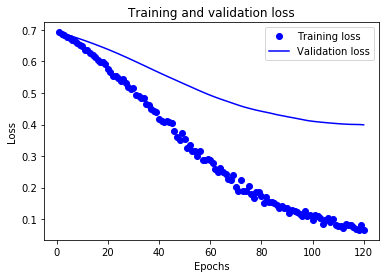

In [164]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

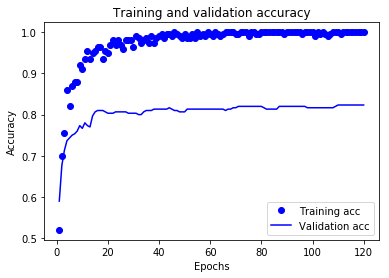

In [165]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()